# Test Data Analysis
Just messin around

In [1]:
# Install libraries
%pip install firebase_admin google-cloud-firestore pandas matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Firebase setup

import firebase_admin
from firebase_admin import credentials, firestore

cred = credentials.Certificate("secrets/firebase_key.json")
firebase_admin.initialize_app(cred)

db = firestore.client()

In [3]:
# Get user data

import firebase_admin
from firebase_admin import auth

email = "alexxander1611@gmail.com"

user = auth.get_user_by_email(email)
print(f'Successfully fetched user data: {user.uid}')

user_info = db.collection('Users').document(user.uid).get().to_dict()
print(user_info)


Successfully fetched user data: hiZJsylQKJNitULApBf4e9XH9vg1


E0000 00:00:1761792596.942727 8209716 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


{'email': 'Alexxander1611@gmail.com', 'uid': 'hiZJsylQKJNitULApBf4e9XH9vg1'}


In [4]:
# Fetch IMU data

import pandas as pd

imu_coll = db.collection('UserIMU').document(user.uid).collection('Sessions')
query = imu_coll.order_by("time", direction=firestore.Query.DESCENDING).limit(1)
user_imu = query.get()[0].to_dict()

rows = []

for device, device_data in user_imu['data'].items():
	for imu_function,data in device_data.items():
		segmentIdx = 0
		for segment in data.values():
			for entry in segment:
				for simd in entry['list']:
					entry = {}
					entry["Device"] = device
					entry['Type'] = imu_function 
					entry['Time'] = simd['readTime']
					entry['Segment'] = segmentIdx
					entry["X"] = simd['read'][0]
					entry["Y"] = simd['read'][1]
					entry["Z"] = simd['read'][2]
					entry['Timestamp'] = user_imu['time']
					rows.append(entry)
			segmentIdx += 1
df = pd.DataFrame(rows)
df

,Device,Type,Time,Segment,X,Y,Z,Timestamp
0,Alpha ,gyro,1.761793e+09,0,4.024390,2.713415,-1.432927,1.761793e+09
1,Alpha ,gyro,1.761793e+09,0,4.847561,3.018293,-1.890244,1.761793e+09
2,Alpha ,gyro,1.761793e+09,0,4.024390,3.475610,-1.158537,1.761793e+09
3,Alpha ,gyro,1.761793e+09,0,3.963415,2.560976,-1.798781,1.761793e+09
4,Alpha ,gyro,1.761793e+09,0,4.146341,3.018293,-1.646341,1.761793e+09
...,...,...,...,...,...,...,...,...
985,Alpha ,planar,1.761793e+09,0,-0.081403,-0.150835,9.950302,1.761793e+09
986,Alpha ,planar,1.761793e+09,0,-0.090980,-0.122104,9.952697,1.761793e+09
987,Alpha ,planar,1.761793e+09,0,-0.167594,-0.174777,9.907207,1.761793e+09
988,Alpha ,planar,1.761793e+09,0,-0.052672,-0.090980,9.902418,1.761793e+09


In [5]:
# Visualize IMU data of a given type

devname = "Alpha\x00"
imutype = "gyro"

dev = df[df['Type'] == imutype].copy()
dev = dev[dev['Device'] == devname].copy()
earliest = dev['Time'].min()
dev['Elapsed'] = dev['Time'] - earliest

dev.head()

,Device,Type,Time,Segment,X,Y,Z,Timestamp,Elapsed
0,Alpha ,gyro,1.761793e+09,0,4.024390,2.713415,-1.432927,1.761793e+09,0.00
1,Alpha ,gyro,1.761793e+09,0,4.847561,3.018293,-1.890244,1.761793e+09,0.01
2,Alpha ,gyro,1.761793e+09,0,4.024390,3.475610,-1.158537,1.761793e+09,0.02
3,Alpha ,gyro,1.761793e+09,0,3.963415,2.560976,-1.798781,1.761793e+09,0.03
4,Alpha ,gyro,1.761793e+09,0,4.146341,3.018293,-1.646341,1.761793e+09,0.04


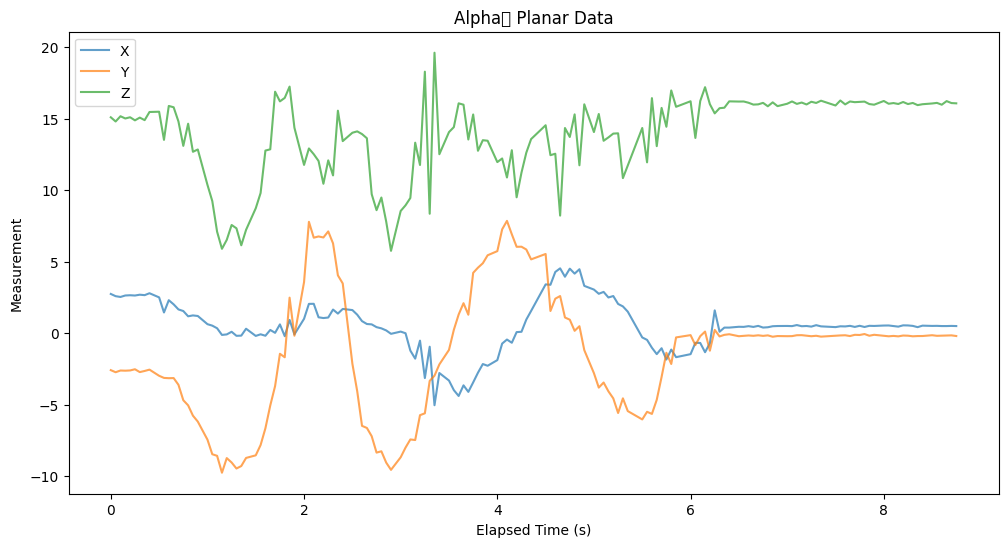

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dev['Elapsed'], dev['X'], label='X', alpha=0.7)
plt.plot(dev['Elapsed'], dev['Y'], label='Y', alpha=0.7)
plt.plot(dev['Elapsed'], dev['Z'], label='Z', alpha=0.7)
plt.title(devname + ' ' + (imutype[0].upper() + imutype[1:]) + ' Data')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Measurement')
plt.legend()
plt.show()

## Collective Data

In [16]:

# Fetch collective data

import pandas as pd

imu_coll = db.collection('UserData').document(user.uid).collection('Sessions')
query = imu_coll.order_by("time", direction=firestore.Query.DESCENDING).limit(1)
user_imu = query.get()[0].to_dict()

rows = []

for device, device_data in user_imu['data'].items():
	for imu_function,data in device_data['_imu'].items():
		segmentIdx = 0
		for segment in data.values():
			for entry in segment:
				for simd in entry['list']:
					entry = {}
					entry["Device"] = device
					entry['Type'] = imu_function 
					entry['Time'] = simd['readTime']
					entry['Segment'] = segmentIdx
					entry["X"] = simd['read'][0]
					entry["Y"] = simd['read'][1]
					entry["Z"] = simd['read'][2]
					entry['Timestamp'] = user_imu['time']
					rows.append(entry)
			segmentIdx += 1
df = pd.DataFrame(rows)
df.head()

,Device,Type,Time,Segment,X,Y,Z,Timestamp
0,Alpha ,gyro,1.761793e+09,0,3.810976,2.743902,-0.914634,1.761793e+09
1,Alpha ,gyro,1.761793e+09,0,3.201220,1.859756,-1.158537,1.761793e+09
2,Alpha ,gyro,1.761793e+09,0,2.743902,3.018293,-1.371951,1.761793e+09
3,Alpha ,gyro,1.761793e+09,0,3.780488,3.536585,-1.920732,1.761793e+09
4,Alpha ,gyro,1.761793e+09,0,4.359756,2.835366,-1.615854,1.761793e+09


In [17]:
# Visualize IMU data of a given type

devname = "Alpha\x00"
imutype = "gyro"

dev = df[df['Type'] == imutype].copy()
dev = dev[dev['Device'] == devname].copy()
earliest = dev['Time'].min()
dev['Elapsed'] = dev['Time'] - earliest

dev

,Device,Type,Time,Segment,X,Y,Z,Timestamp,Elapsed
0,Alpha ,gyro,1.761793e+09,0,3.810976,2.743902,-0.914634,1.761793e+09,0.000000
1,Alpha ,gyro,1.761793e+09,0,3.201220,1.859756,-1.158537,1.761793e+09,0.010000
2,Alpha ,gyro,1.761793e+09,0,2.743902,3.018293,-1.371951,1.761793e+09,0.020000
3,Alpha ,gyro,1.761793e+09,0,3.780488,3.536585,-1.920732,1.761793e+09,0.030000
4,Alpha ,gyro,1.761793e+09,0,4.359756,2.835366,-1.615854,1.761793e+09,0.040000
...,...,...,...,...,...,...,...,...,...
315,Alpha ,gyro,1.761793e+09,0,-100.609756,-0.609756,17.682928,1.761793e+09,4.910000
316,Alpha ,gyro,1.761793e+09,0,-49.024391,23.323172,6.524390,1.761793e+09,4.920003
317,Alpha ,gyro,1.761793e+09,0,-56.615856,27.439026,17.378050,1.761793e+09,4.930000
318,Alpha ,gyro,1.761793e+09,0,-108.932930,25.396341,-3.231707,1.761793e+09,4.940000


/Users/callum/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 0 ( ) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


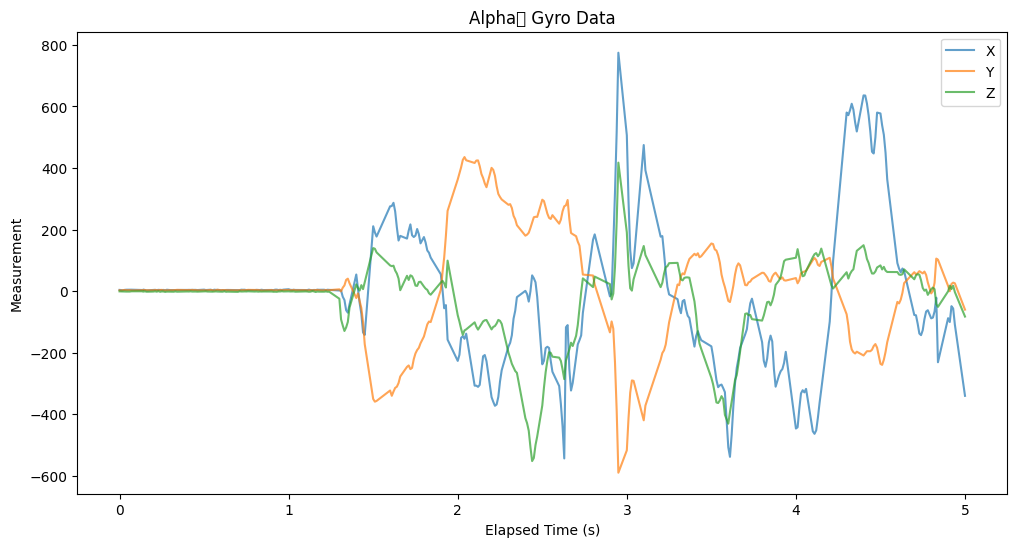

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dev['Elapsed'], dev['X'], label='X', alpha=0.7)
plt.plot(dev['Elapsed'], dev['Y'], label='Y', alpha=0.7)
plt.plot(dev['Elapsed'], dev['Z'], label='Z', alpha=0.7)
plt.title(devname + ' ' + (imutype[0].upper() + imutype[1:]) + ' Data')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Measurement')
plt.legend()
plt.show()

Copyright © 2025 Callum Mackenzie